In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

# KILL ME 

In [68]:
# Read CSV into a DataFrame
df = pd.read_csv("128by128lowRe/diagnostics.csv")
# Show first 5 rows
print(df.head())
def extract_time_evolution(x_position):
    mask = df["x"] == x_position
    
    time = df.loc[mask, "t"].to_numpy()
    U_LS = df.loc[mask, "U_LS"].to_numpy()
    return time, U_LS

T, U_LS = extract_time_evolution('2')

     t        x       A_L       A_G     U_LS      U_GS      V_L       V_G  \
0  0.0        0  0.782086  0.003367  1.00001  0.000045      NaN       NaN   
1  0.0        2  0.782086  0.003367  1.00001  0.000045      NaN       NaN   
2  0.0        4  0.782086  0.003367  1.00001  0.000045      NaN       NaN   
3  0.0  VOLUMES       NaN       NaN      NaN       NaN  3.51939  0.015153   
4  0.2        0  0.782085  0.003368  0.89619  0.000085      NaN       NaN   

   V_total   V_pipe  
0      NaN      NaN  
1      NaN      NaN  
2      NaN      NaN  
3  3.53454  3.53429  
4      NaN      NaN  


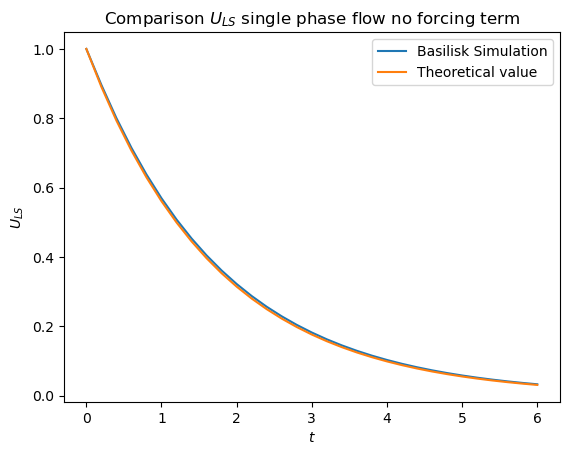

In [69]:
plt.plot(T, U_LS, label="Basilisk Simulation")
plt.plot(T, np.exp(-(4.8096)**2 * (1/40) * T), label="Theoretical value")
plt.ylabel(r"$U_{LS} $")           # LaTeX in x-axis label
plt.xlabel(r"$t $")               # LaTeX in y-axis label
plt.title(r"Comparison $U_{LS}$ single phase flow no forcing term")
plt.legend()

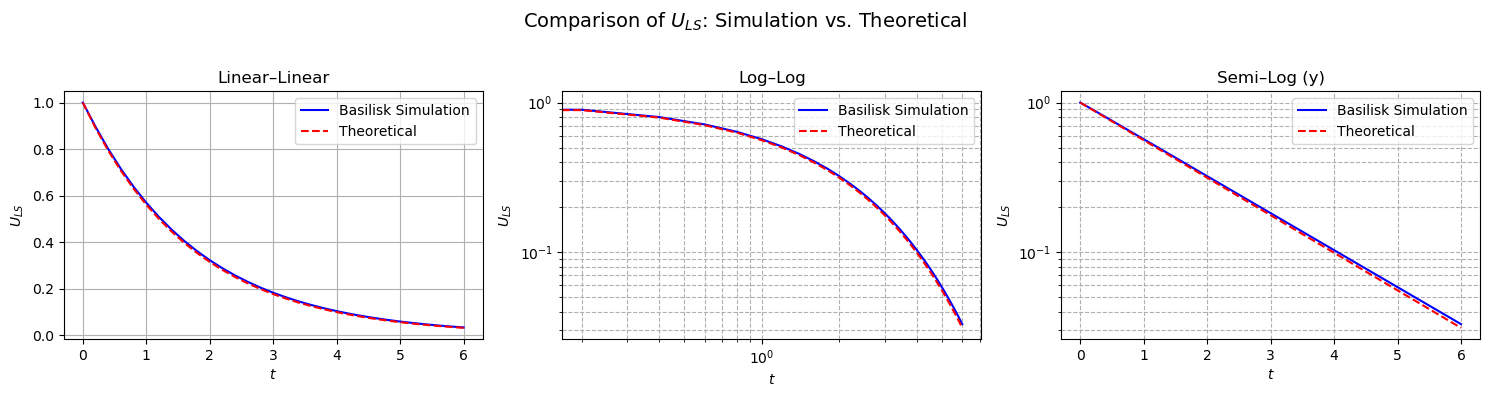

In [70]:
# --- Create 1×3 subplots ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# --- Precompute theoretical curve ---
theoretical = np.exp(-(4.8096)**2 * (1/40) * T)

# --- 1️⃣ Linear plot ---
axes[0].plot(T, U_LS, 'b-', label="Basilisk Simulation")
axes[0].plot(T, theoretical, 'r--', label="Theoretical")
axes[0].set_xlabel(r"$t$")
axes[0].set_ylabel(r"$U_{LS}$")
axes[0].set_title("Linear–Linear")
axes[0].legend()
axes[0].grid(True)

# --- 2️⃣ Log–Log plot ---
axes[1].loglog(T, U_LS, 'b-', label="Basilisk Simulation")
axes[1].loglog(T, theoretical, 'r--', label="Theoretical")
axes[1].set_xlabel(r"$t$")
axes[1].set_ylabel(r"$U_{LS}$")
axes[1].set_title("Log–Log")
axes[1].legend()
axes[1].grid(True, which="both", ls='--')

# --- 3️⃣ Semi–log (y-axis log scale) ---
axes[2].semilogy(T, U_LS, 'b-', label="Basilisk Simulation")
axes[2].semilogy(T, theoretical, 'r--', label="Theoretical")
axes[2].set_xlabel(r"$t$")
axes[2].set_ylabel(r"$U_{LS}$")
axes[2].set_title("Semi–Log (y)")
axes[2].legend()
axes[2].grid(True, which="both", ls='--')

# --- Final layout ---
fig.suptitle(r"Comparison of $U_{LS}$: Simulation vs. Theoretical", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# --- Save figure ---
plt.savefig("comparison_ULS_subplots.png", dpi=300)
plt.show()

# Cross-Section

In [50]:
def extract_slice(x_position):
    mask = Data_time["x"] == x_position
    
    coords = Data_time.loc[mask, ["x", "y", "z"]].to_numpy()
    u_x = Data_time.loc[mask, "u.x"].to_numpy()
    u_y = Data_time.loc[mask, "u.y"].to_numpy()
    u_z = Data_time.loc[mask, "u.z"].to_numpy()
    f   = Data_time.loc[mask, "f"].to_numpy()
    
    return coords, u_x, u_y, u_z, f

def plot_cross_section(coords, values, label="value", title="Cross-section", ax=None, vmin=None, vmax=None):
    """
    Plot cross-section heatmap for a given velocity component.
    - coords: Nx3 array, with y=coords[:,1], z=coords[:,2]
    - values: corresponding variable values (e.g., u_x)
    - vmin, vmax: manual color limits (optional)
    """
    y = coords[:, 1]   # vertical axis
    z = coords[:, 2]   # horizontal axis

    if ax is None:
        ax = plt.gca()

    contour = ax.tricontourf(z, y, values, levels=50, cmap="jet", vmin=vmin, vmax=vmax)

    # Draw pipe boundary (circle)
    circle = plt.Circle((0, 0), 0.5, color="black", fill=False, linewidth=2)
    ax.add_patch(circle)

    ax.set_xlabel("z (horizontal)")
    ax.set_ylabel("y (vertical)")
    ax.set_title(title)
    ax.set_aspect("equal")

    return contour

def superficial(coords, ux, f):
    y = coords[:,1]
    z = coords[:,2]
    
    # Estimate grid spacing (assuming uniform)
    dy = np.min(np.diff(np.sort(np.unique(y))))
    dz = np.min(np.diff(np.sort(np.unique(z))))
    delta_area = dy * dz
    cross_section = np.pi * (0.5**2)
    
    U_ls = 0.0
    U_gs = 0.0
    A_g = 0.0
    A_l = 0.0
    
    total = coords.shape[0]
    for i in range(total):
        # Skip points outside the pipe radius
        if y[i]**2 + z[i]**2 > (0.5**2):
            continue
        # Accumulate contributions
        U_ls += f[i] * ux[i] * delta_area/cross_section
        U_gs += (1 - f[i]) * ux[i] * delta_area/cross_section
        A_g += f[i] * delta_area
        A_l += (1 - f[i]) * delta_area

    return U_ls, U_gs, A_l, A_g

def extract_slice_xy(z_position):
    mask = Data_time["z"] == z_position
    
    coords = Data_time.loc[mask, ["x", "y", "z"]].to_numpy()
    u_x = Data_time.loc[mask, "u.x"].to_numpy()
    u_y = Data_time.loc[mask, "u.y"].to_numpy()
    u_z = Data_time.loc[mask, "u.z"].to_numpy()
    f   = Data_time.loc[mask, "f"].to_numpy()
    
    return coords, u_x, u_y, u_z, f

def plot_slice_xy(coords, values, aspect_ratio, label="value", title="slice xy"):
    y = coords[:,1]   # vertical axis
    x = coords[:,0]   # horizontal axis
    
    plt.figure(figsize=(2*aspect_ratio,2))
    contour = plt.tricontourf(x, y, values, levels=50, cmap="jet")
    plt.colorbar(contour, label=label)
    
    # Draw straight lines at y = ±0.5
    plt.axhline(0.5, color="black", linestyle="--", linewidth=2)
    plt.axhline(-0.5, color="black", linestyle="--", linewidth=2)
    
    plt.xlabel("x (horizontal)")
    plt.ylabel("y (vertical)")
    plt.title(title)
    plt.show()

def volume_calculation(coords, f, radius=0.5):
    x = coords[:,0]
    y = coords[:,1]
    z = coords[:,2]
    
    # Estimate grid spacing (assuming uniform structured grid)
    dx = np.min(np.diff(np.unique(x)))
    dy = np.min(np.diff(np.unique(y)))
    dz = np.min(np.diff(np.unique(z)))
    delta_volume = dx * dy * dz
    
    V_l = 0.0
    V_g = 0.0
    total = coords.shape[0]
    
    for i in range(total):
        # Skip cells outside the pipe radius
        if y[i]**2 + z[i]**2 > radius**2:
            continue
        # Accumulate contributions
        V_l += f[i] * delta_volume
        V_g += (1 - f[i]) * delta_volume
    
    return V_l, V_g

def volume_calculation(coords, f, radius=0.5):
    x = coords[:,0]
    y = coords[:,1]
    z = coords[:,2]

    # Only compute dx, dy, dz if there’s more than one unique value
    def spacing(arr):
        uniq = np.unique(arr)
        return np.min(np.diff(uniq)) if uniq.size > 1 else 1.0  # fallback
    
    dx = spacing(x)
    dy = spacing(y)
    dz = spacing(z)
    delta_volume = dx * dy * dz
    
    V_l = 0.0
    V_g = 0.0
    
    for i in range(coords.shape[0]):
        if y[i]**2 + z[i]**2 > radius**2:
            continue
        V_l += f[i] * delta_volume
        V_g += (1 - f[i]) * delta_volume
    
    return V_l, V_g

def average_centerline_velocity(data, tol=1e-6):
    """
    Compute average axial velocity (u.x) along the pipe centerline (y=z=0).

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing columns ['x', 'y', 'z', 'u.x'].
    tol : float
        Numerical tolerance to consider y and z as zero (default: 1e-6).

    Returns
    -------
    float
        Average u.x value along the centerline.
    """
    # Filter points where y and z are approximately zero
    centerline_points = data[(np.abs(data['y']) < tol) & (np.abs(data['z']) < tol)]

    if centerline_points.empty:
        print("⚠️ No points found at centerline (check your tolerance or grid resolution).")
        return np.nan

    # Compute mean of u.x
    avg_ux = centerline_points['u.x'].mean()

    print(f"Average centerline u.x = {avg_ux:.6f} (computed from {len(centerline_points)} points)")
    return avg_ux

In [51]:
# Read CSV into a DataFrame
Data_time = pd.read_csv("cell_dump_t4.0000_all.csv")
# Show first 5 rows
print(Data_time.head())

FileNotFoundError: [Errno 2] No such file or directory: 'cell_dump_t4.0000_all.csv'

In [ ]:
# Read CSV into a DataFrame
Data_time = pd.read_csv("cell_dump_t1.2000_all.csv")
# Show first 5 rows
print(Data_time.head())

In [ ]:
unique_x = Data_time["x"].unique()
print(unique_x[4])

unique_z = Data_time["z"].unique()
print(unique_z[63])

In [ ]:
# --- Example: extract slice ---
coords_1, u_x1, u_y1, u_z1, f1 = extract_slice(unique_x[163])

# --- Manually set color ranges for each variable ---
vmin_x, vmax_x = 0.0, 2.5
vmin_y, vmax_y = -1.0, 1.0
vmin_z, vmax_z = -1.0, 1.0

# --- Create subplots ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- Plot each velocity component with its own color limits ---
contour1 = plot_cross_section(coords_1, u_x1, label="u_x", title=f"u_x at x={unique_x[163]}",
                              ax=axes[0], vmin=vmin_x, vmax=vmax_x)
contour2 = plot_cross_section(coords_1, u_y1, label="u_y", title=f"u_y at x={unique_x[163]}",
                              ax=axes[1], vmin=vmin_y, vmax=vmax_y)
contour3 = plot_cross_section(coords_1, u_z1, label="u_z", title=f"u_z at x={unique_x[163]}",
                              ax=axes[2], vmin=vmin_z, vmax=vmax_z)

# --- Add colorbars ---
for contour, ax, lbl in zip([contour1, contour2, contour3], axes, ["u_x", "u_y", "u_z"]):
    cbar = fig.colorbar(contour, ax=ax, orientation="vertical")
    cbar.set_label(lbl)

plt.tight_layout()
plt.show()

# Testing 

In [22]:
final_time = 3.2
Reynold_number = 40

np.exp(-(4.81)**2 * (1/Reynold_number) * final_time)

0.15709760168580697

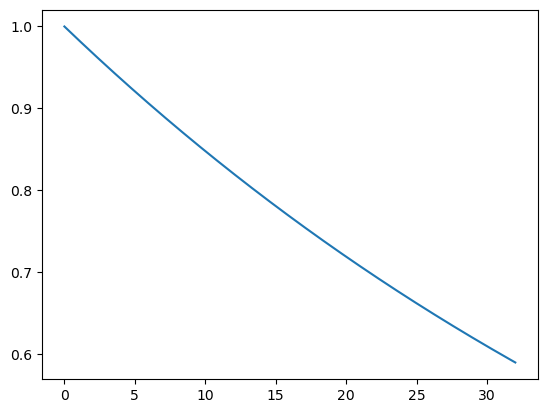

In [23]:
kill_me = np.linspace(0,final_time*10,1000)
plt.plot(kill_me, np.exp(-(4.81)**2 * (1/1400) * kill_me))

# 128by128 Low Re

In [ ]:
# --- Your time steps ---
#time_list = [0.0000, 2.0000, 4.0000, 6.0000, 8.0000, 10.0000]

# --- Generate time list automatically ---
# time_list = np.arange(0.0, 6.0001, 0.2000)  # from 0.0000 to 6.0000 inclusive
time_list = np.arange(2.4, 6.0001, 0.2000)  # from 0.0000 to 6.0000 inclusive
centerline_vel = [] 

# --- Loop over time files ---
for t in time_list:
    filename = f"128by128lowRe/Output_field/cell_dump_t{t:.4f}_all.csv"
    print(f"Processing {filename} ...")

    # Load the CSV globally so extract_slice() can use it
    Data_time = pd.read_csv(filename)
    unique_x = Data_time["x"].unique()
    avg_centerline = average_centerline_velocity(Data_time, tol=1e-2)

    centerline_vel.append(Data_time)
    # --- Extract slice at x = unique_x[163] ---
    coords_1, u_x1, u_y1, u_z1, f1 = extract_slice(unique_x[163])

    # --- Set manual color limits ---
    vmin_x, vmax_x = 0.0, 2.5
    vmin_y, vmax_y = -1.0, 1.0
    vmin_z, vmax_z = -1.0, 1.0

    # --- Create subplots ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # --- Plot each component ---
    contour1 = plot_cross_section(coords_1, u_x1, label="u_x", title=f"u_x at t={t:.4f}",
                                  ax=axes[0], vmin=vmin_x, vmax=vmax_x)
    contour2 = plot_cross_section(coords_1, u_y1, label="u_y", title=f"u_y at t={t:.4f}",
                                  ax=axes[1], vmin=vmin_y, vmax=vmax_y)
    contour3 = plot_cross_section(coords_1, u_z1, label="u_z", title=f"u_z at t={t:.4f}",
                                  ax=axes[2], vmin=vmin_z, vmax=vmax_z)

    # --- Add colorbars ---
    for contour, ax, lbl in zip([contour1, contour2, contour3], axes, ["u_x", "u_y", "u_z"]):
        cbar = fig.colorbar(contour, ax=ax, orientation="vertical")
        cbar.set_label(lbl)

    plt.tight_layout()

    # --- Save figure ---
    outname = f"velocity_cross_section_t{t:.4f}.png"
    plt.savefig(outname, dpi=300)
    plt.close(fig)

    print(f"Saved {outname}")


Processing 128by128lowRe/Output_field/cell_dump_t2.4000_all.csv ...
Average centerline u.x = 0.585768 (computed from 2048 points)
Saved velocity_cross_section_t2.4000.png
Processing 128by128lowRe/Output_field/cell_dump_t2.6000_all.csv ...
Average centerline u.x = 0.522670 (computed from 2048 points)
Saved velocity_cross_section_t2.6000.png
Processing 128by128lowRe/Output_field/cell_dump_t2.8000_all.csv ...
Average centerline u.x = 0.466370 (computed from 2048 points)
Saved velocity_cross_section_t2.8000.png
Processing 128by128lowRe/Output_field/cell_dump_t3.0000_all.csv ...
Average centerline u.x = 0.416137 (computed from 2048 points)
Saved velocity_cross_section_t3.0000.png
Processing 128by128lowRe/Output_field/cell_dump_t3.2000_all.csv ...
Average centerline u.x = 0.371315 (computed from 2048 points)
Saved velocity_cross_section_t3.2000.png
Processing 128by128lowRe/Output_field/cell_dump_t3.4000_all.csv ...
Average centerline u.x = 0.331321 (computed from 2048 points)
Saved velocity_

# Centerline velocity 

In [2]:
centerline_ux = [
    2.316060, 2.063220, 1.838050, 1.637880,
    1.460070, 1.302000, 1.161300, 1.035970,
    0.924246, 0.824621, 0.735760, 0.656490,
    0.585768, 0.522670, 0.466370, 0.416137,
    0.371315, 0.331321, 0.295635, 0.263792,
    0.233580, 0.210028, 0.187406, 0.167221,
    0.149210, 0.133139, 0.118799, 0.106003,
    0.094586, 0.084398, 0.075308
]
time_list = [
    0.0000, 0.2000, 0.4000, 0.6000,
    0.8000, 1.0000, 1.2000, 1.4000,
    1.6000, 1.8000, 2.0000, 2.2000,
    2.4000, 2.6000, 2.8000, 3.0000,
    3.2000, 3.4000, 3.6000, 3.8000,
    4.0000, 4.2000, 4.4000, 4.6000,
    4.8000, 5.0000, 5.2000, 5.4000,
    5.6000, 5.8000, 6.0000
]


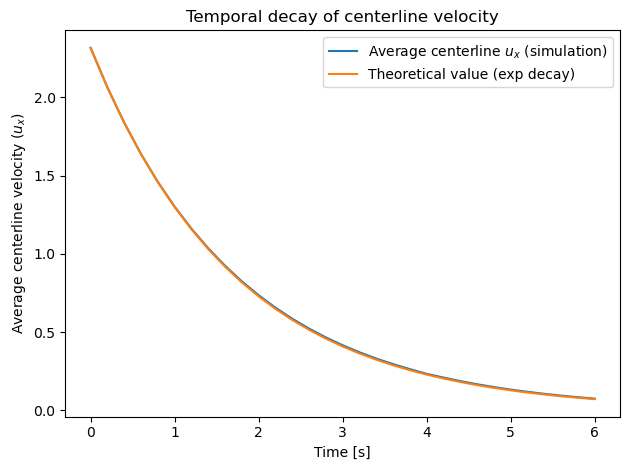

In [38]:
# Convert list to numpy array
time_arr = np.array(time_list)
# Plot simulation data
plt.plot(time_arr, centerline_ux, label='Average centerline $u_x$ (simulation)')
# Plot theoretical exponential decay
plt.plot(time_arr, 2.31606 * np.exp(-(4.8096)**2 * (1/40) * time_arr),
         label="Theoretical value (exp decay)")

# Labels and formatting
plt.xlabel('Time [s]')
plt.ylabel('Average centerline velocity ($u_x$)')
plt.title('Temporal decay of centerline velocity')
plt.legend()
plt.tight_layout()
plt.show()

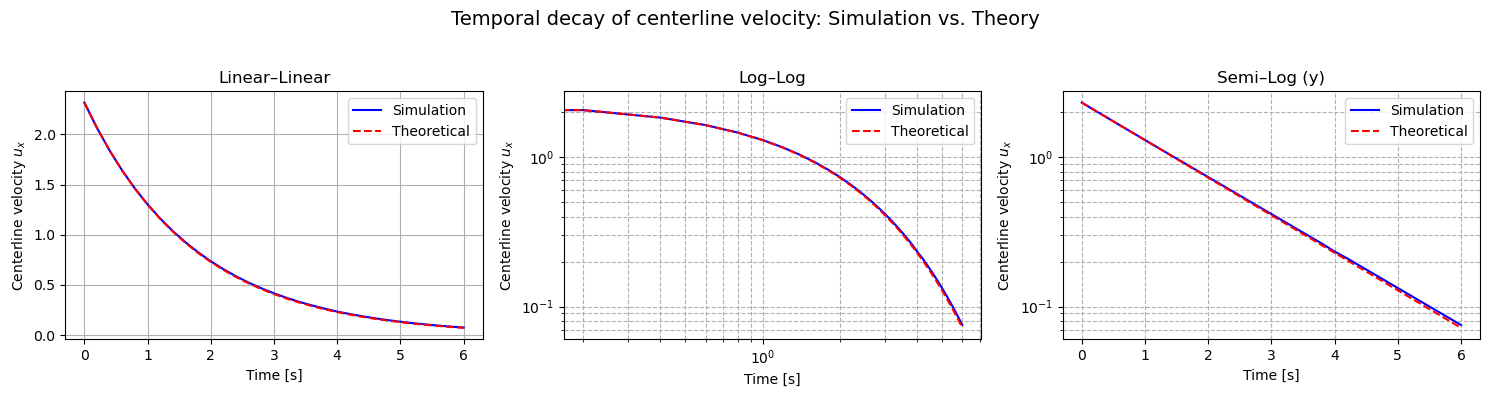

In [72]:
# --- Convert list to numpy array ---
time_arr = np.array(time_list)
theoretical = 2.31606 * np.exp(-(4.8096)**2 * (1/40) * time_arr)

# --- Create 1×3 subplot figure ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# --- 1️⃣ Linear–Linear plot ---
axes[0].plot(time_arr, centerline_ux, 'b-', label='Simulation')
axes[0].plot(time_arr, theoretical, 'r--', label='Theoretical')
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel(r'Centerline velocity $u_x$')
axes[0].set_title('Linear–Linear')
axes[0].legend()
axes[0].grid(True)

# --- 2️⃣ Log–Log plot ---
axes[1].loglog(time_arr, centerline_ux, 'b-', label='Simulation')
axes[1].loglog(time_arr, theoretical, 'r--', label='Theoretical')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel(r'Centerline velocity $u_x$')
axes[1].set_title('Log–Log')
axes[1].legend()
axes[1].grid(True, which='both', ls='--')

# --- 3️⃣ Semi–log (y-axis log scale) ---
axes[2].semilogy(time_arr, centerline_ux, 'b-', label='Simulation')
axes[2].semilogy(time_arr, theoretical, 'r--', label='Theoretical')
axes[2].set_xlabel('Time [s]')
axes[2].set_ylabel(r'Centerline velocity $u_x$')
axes[2].set_title('Semi–Log (y)')
axes[2].legend()
axes[2].grid(True, which='both', ls='--')

# --- Layout & save ---
fig.suptitle('Temporal decay of centerline velocity: Simulation vs. Theory', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("centerline_velocity_decay_subplots.png", dpi=300)
plt.show()

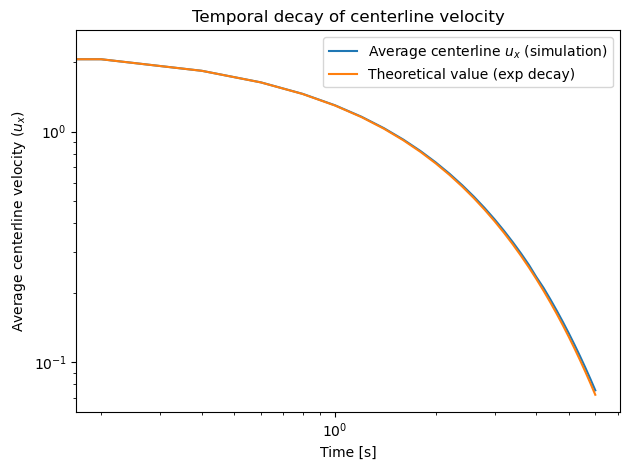

In [29]:
# Convert list to numpy array
time_arr = np.array(time_list)
# Plot simulation data
plt.loglog(time_arr, centerline_ux, label='Average centerline $u_x$ (simulation)')
# Plot theoretical exponential decay
plt.loglog(time_arr, 2.31606 * np.exp(-(4.81)**2 * (1/40) * time_arr),
         label="Theoretical value (exp decay)")

# Labels and formatting
plt.xlabel('Time [s]')
plt.ylabel('Average centerline velocity ($u_x$)')
plt.title('Temporal decay of centerline velocity')
plt.legend()
plt.tight_layout()
plt.show()

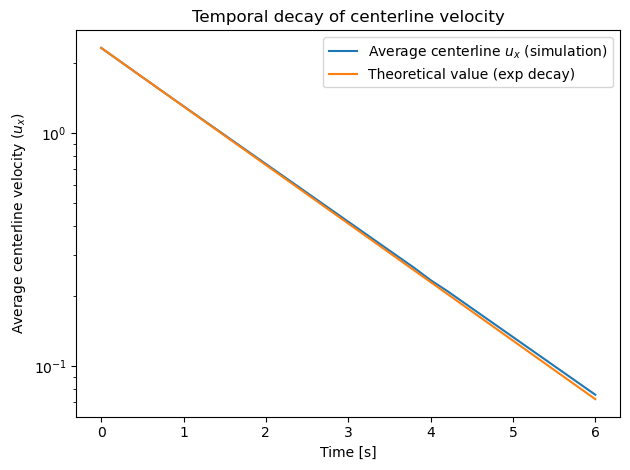

In [42]:
# Convert list to numpy array
time_arr = np.array(time_list)
# Plot simulation data
plt.semilogy(time_arr, centerline_ux, label='Average centerline $u_x$ (simulation)')
# Plot theoretical exponential decay
plt.semilogy(time_arr, 2.31606 * np.exp(-(4.8096)**2 * (1/40) * time_arr),
         label="Theoretical value (exp decay)")

# Labels and formatting
plt.xlabel('Time [s]')
plt.ylabel('Average centerline velocity ($u_x$)')
plt.title('Temporal decay of centerline velocity')
plt.legend()
plt.tight_layout()
plt.show()

# Cross-section

Theoretical,

$$
U(r,t) = (2.32) \cdot e^{-(4.81)^{2} \frac{1}{\mathrm{Re}} t} \cdot J_{0}(4.81 r)
$$

In [42]:
# Load the CSV globally so extract_slice() can use it
t = 5
filename = f"128by128lowRe/Output_field/cell_dump_t{t:.4f}_all.csv"
Data_time = pd.read_csv(filename)
unique_x = Data_time["x"].unique()
coords_1, u_x1, u_y1, u_z1, f1 = extract_slice(unique_x[163])

In [43]:
def theoretical_value(spec_time,radius):
    radius = np.array(radius)
    exponential_term = np.exp(-(4.8096**2)*(1/40)*spec_time)
    J0 = special.jv(0, radius * 4.8096)   # Zero-order Bessel function J0(x)
    return 2.31658187369 * exponential_term * J0

In [44]:
x = coords_1[:,0]
y = coords_1[:,1]
z = coords_1[:,2]
radius = np.sqrt(y**2 + z**2)
theoretical_axial_vel = theoretical_value(t,radius)
theoretical_axial_vel = np.array(theoretical_axial_vel)
radius = np.array(radius)

theoretical_axial_vel[radius > 0.5] = 0.0

In [45]:
# Compute relative error safely
with np.errstate(divide='ignore', invalid='ignore'):
    rel_error = np.abs((u_x1 - theoretical_axial_vel) / u_x1)
    # Replace inf/nan with 0 (or np.nan if you want them excluded)
    rel_error[~np.isfinite(rel_error)] = 0.0

fig = plt.figure()
contour = plot_cross_section(coords_1, rel_error, label="u_x",
                             title=f"relative error at x={unique_x[163]}", ax=None,
                             vmin=0, vmax=1)

cbar = fig.colorbar(contour, orientation="vertical")
cbar.set_label("Relative error |(u_sim - u_th)/u_sim|")

plt.tight_layout()

# ✅ Save BEFORE showing
outname = f"relative_error_t{t:.1f}.png"
fig.savefig(outname, dpi=300)  # use fig, not plt
plt.close(fig)  # closes the figure to free memory

print(f"Saved {outname}")


Saved relative_error_t5.0.png


In [65]:
# Load the CSV globally so extract_slice() can use it
t = 6
filename = f"128by128lowRe/Output_field/cell_dump_t{t:.4f}_all.csv"
Data_time = pd.read_csv(filename)
unique_x = Data_time["x"].unique()
coords_1, u_x1, u_y1, u_z1, f1 = extract_slice(unique_x[163])
x = coords_1[:,0]
y = coords_1[:,1]
z = coords_1[:,2]
radius = np.sqrt(y**2 + z**2)
theoretical_axial_vel = theoretical_value(t,radius)
theoretical_axial_vel = np.array(theoretical_axial_vel)
radius = np.array(radius)

theoretical_axial_vel[radius > 0.5] = 0.0

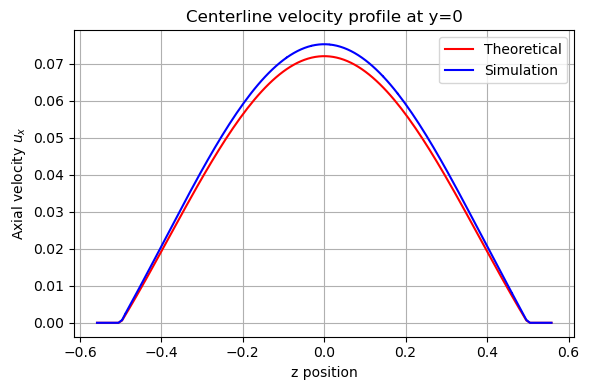

In [66]:
# --- Select centerline points where y ≈ 0 ---
tol = 1e-2# tolerance for floating-point
center_mask = np.abs(y) < tol

# --- Extract z and corresponding theoretical velocity ---
z_center = z[center_mask]
u_th_center = theoretical_axial_vel[center_mask]

# --- Sort by z for a nice line plot ---
sort_idx = np.argsort(z_center)
z_center_sorted = z_center[sort_idx]
u_th_sorted = u_th_center[sort_idx]

# --- Plot ---
plt.figure(figsize=(6,4))
plt.plot(z_center_sorted, u_th_sorted, 'r-', label='Theoretical')
plt.plot(z_center_sorted, u_x1[center_mask][sort_idx], 'b-', label='Simulation')
plt.legend()
plt.xlabel('z position')
plt.ylabel('Axial velocity $u_x$')
plt.title('Centerline velocity profile at y=0')
plt.grid(True)
plt.tight_layout()
outname = f"velocity_profile_{t:.1f}.png"
plt.savefig(outname, dpi=300)
plt.show()
plt.close()


In [36]:
z_center

array([-0.558105  , -0.549316  , -0.540527  , -0.531738  , -0.522949  ,
       -0.51416   , -0.505371  , -0.496582  , -0.487793  , -0.479004  ,
       -0.470215  , -0.461426  , -0.452637  , -0.443848  , -0.435059  ,
       -0.42627   , -0.41748   , -0.408691  , -0.399902  , -0.391113  ,
       -0.382324  , -0.373535  , -0.364746  , -0.355957  , -0.347168  ,
       -0.338379  , -0.32959   , -0.320801  , -0.312012  , -0.303223  ,
       -0.294434  , -0.285645  , -0.276855  , -0.268066  , -0.259277  ,
       -0.250488  , -0.241699  , -0.23291   , -0.224121  , -0.215332  ,
       -0.206543  , -0.197754  , -0.188965  , -0.180176  , -0.171387  ,
       -0.162598  , -0.153809  , -0.14502   , -0.13623   , -0.127441  ,
       -0.118652  , -0.109863  , -0.101074  , -0.0922852 , -0.0834961 ,
       -0.074707  , -0.065918  , -0.0571289 , -0.0483398 , -0.0395508 ,
       -0.0307617 , -0.0219727 , -0.0131836 , -0.00439453,  0.00439453,
        0.0131836 ,  0.0219727 ,  0.0307617 ,  0.0395508 ,  0.04